In [ ]:
"""
Copyright (C) 2014 John Evans

This example code illustrates how to access and visualize an LP DAAC MOD13C2
v6 HDF-EOS2 Grid file in Python.

If you have any questions, suggestions, or comments on this example, please use
the HDF-EOS Forum (http://hdfeos.org/forums).  If you would like to see an
example of any other NASA HDF/HDF-EOS data product that is not listed in the
HDF-EOS Comprehensive Examples page (http://hdfeos.org/zoo), feel free to
contact us at eoshelp@hdfgroup.org or post it at the HDF-EOS Forum
(http://hdfeos.org/forums).

Usage:  save this script and run

    $python MOD13C2.A2007001.006.2015161222701.hdf.py

The HDF file must be in your current working directory.

Tested under: Python 2.7.14 :: Anaconda custom (64-bit)
Last updated: 2018-04-13
"""

import os
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pyhdf.SD import SD, SDC
import cartopy.crs as ccrs
import xarray as xr
import ipdb
import datetime
import glob
import os



In [ ]:

FILE_NAME = '/media/ck/Elements/global/NDVI_monthly/MOD13C2.A2000336.006.2015147121623.hdf'
#FILE_NAME = 'MOD13C2.A2007001.006.2015161222701.hdf'

# Identify the data field.
DATAFIELD_NAME = 'CMG 0.05 Deg Monthly NDVI'

hdf = SD(FILE_NAME, SDC.READ)

# Read dataset.
data2D = hdf.select(DATAFIELD_NAME)
data = data2D[:,:].astype(np.double)

# Read attributes.
attrs = data2D.attributes(full=1)
lna=attrs["long_name"]
long_name = lna[0]
vra=attrs["valid_range"]
valid_range = vra[0]
aoa=attrs["add_offset"]
add_offset = aoa[0]
fva=attrs["_FillValue"]
_FillValue = fva[0]
sfa=attrs["scale_factor"]
scale_factor = sfa[0]        
ua=attrs["units"]
units = ua[0]

# Handle fill value.
invalid = data == _FillValue
invalid = np.logical_or(invalid, data < valid_range[0])
invalid = np.logical_or(invalid, data > valid_range[1])
data[invalid] = np.nan

# Apply scale factor and offset.
data = (data - add_offset) / scale_factor 
data = np.ma.masked_array(data, np.isnan(data))
        
# Normally we would use the grid metadata to reconstruct the grid, but
# the grid metadata is incorrect in this case, specifically the upper left
# and lower right coordinates of the grid.  We'll construct the grid
# manually, taking into account the fact that we're going to subset the
# data by a factor of 10 (the grid size is 3600 x 7200).
x = np.linspace(-180, 180, 7200)
y = np.linspace(90, -90, 3600)
lon, lat = np.meshgrid(x, y)

In [91]:
def read_modis_monthly(FILE_NAME, dnames=None, save=False):
    # Identify the data field.
    
#     fields = ['CMG 0.05 Deg Monthly NDVI']
#     DATAFIELD_NAME = 'CMG 0.05 Deg Monthly NDVI'
    print('Doing ',FILE_NAME)

    out = FILE_NAME.replace('.hdf', '.nc')
    if os.path.isfile(out):
        print('File exists, return')
        return

    hdf = SD(FILE_NAME, SDC.READ)
    
    if dnames is None:
        dnames = hdf.datasets().keys()
    
    ds = xr.Dataset()
    
    # Normally we would use the grid metadata to reconstruct the grid, but
    # the grid metadata is incorrect in this case, specifically the upper left
    # and lower right coordinates of the grid.  We'll construct the grid
    # manually, taking into account the fact that we're going to subset the
    # data by a factor of 10 (the grid size is 3600 x 7200).
    lon = np.linspace(-180, 180, 7200)
    lat = np.linspace(90, -90, 3600)
    #lon, lat = np.meshgrid(x, y)
    
    split_date = FILE_NAME.split('.')[1]
    year = split_date[1:5]
    
    date = datetime.datetime(int(year), 1, 1) + pd.Timedelta(str(int(split_date[5:8]) - 1)+' days')
    
    #ipdb.set_trace()
    
    for DATAFIELD_NAME in dnames:

        # Read dataset.
        data2D = hdf.select(DATAFIELD_NAME)
        data = data2D[:,:].astype(np.double)

        # Read attributes.
        attrs = data2D.attributes(full=1)
        lna=attrs["long_name"]
        long_name = lna[0]
        vra=attrs["valid_range"]
        valid_range = vra[0]
        try:
            aoa=attrs["add_offset"]
            add_offset = aoa[0]
        except:
            pass
        fva=attrs["_FillValue"]
        _FillValue = fva[0]
        try:
            sfa=attrs["scale_factor"]
            scale_factor = sfa[0]
        except:
            pass
        ua=attrs["units"]
        units = ua[0]

        # Handle fill value.
        invalid = data == _FillValue
        invalid = np.logical_or(invalid, data < valid_range[0])
        invalid = np.logical_or(invalid, data > valid_range[1])
        data[invalid] = np.nan

        # Apply scale factor and offset.
        data = (data - add_offset) / scale_factor 
       # ipdb.set_trace()
        #data = np.ma.masked_array(data, np.isnan(data))
        
        da = xr.DataArray(data[None, ...], coords={'time': np.array([date]),
                                             'lat': lat,
                                             'lon': lon},
                      dims=['time', 'lat', 'lon'])  # .isel(time=0)
        
        ds[DATAFIELD_NAME] = da
        
    if save:
        comp = dict(zlib=True, complevel=5)
        encoding = {var: comp for var in ds.data_vars}
        
        
        ds.to_netcdf(path=out, mode='w', encoding=encoding, format='NETCDF4')
        return
        
    return ds

In [1]:
test = read_modis_monthly(FILE_NAME, dnames=['Day_view_time'])

NameError: name 'read_modis_monthly' is not defined

In [92]:
files = glob.glob( '/media/ck/Elements/global/NDVI_monthly/*.hdf')

In [93]:
for f in files:
    test = read_modis_monthly(f, dnames=['CMG 0.05 Deg Monthly NDVI'], save=True)

Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2000032.006.2015147122546.hdf
File exists, return
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2000061.006.2015147114337.hdf
File exists, return
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2000092.006.2015147120158.hdf
File exists, return
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2000122.006.2015147120137.hdf
File exists, return
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2000153.006.2015147120153.hdf
File exists, return
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2000183.006.2015147120151.hdf
File exists, return
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2000214.006.2015147114343.hdf
File exists, return
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2000245.006.2015147121321.hdf
File exists, return
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2020122.006.2020162030221.hdf
File exists, return
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A

Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2015335.006.2016007184409.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2017001.006.2017034082650.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2018032.006.2018066192357.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2019060.006.2019087145725.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2020092.006.2020130025751.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2014335.006.2015295013117.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2015001.006.2015295122646.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2015032.006.2015297012914.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2015060.006.2015299004320.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2015091.006.2015299130449.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2015121.006.2015301025050.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2015152.00

Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2008001.006.2015170050942.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2008032.006.2015172155027.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2008061.006.2015173035820.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2008092.006.2015173193511.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2006091.006.2015161155537.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2006121.006.2015161164239.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2006152.006.2015161175917.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2006182.006.2015161193917.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2006213.006.2015161200559.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2006244.006.2015161210216.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2006274.006.2015161210513.hdf
Doing  /media/ck/Elements/global/NDVI_monthly/MOD13C2.A2006305.00

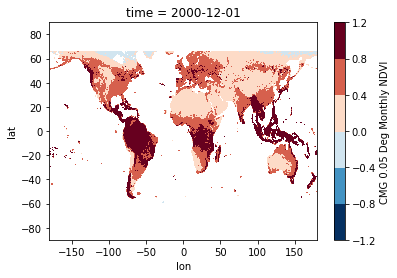

In [78]:
test['CMG 0.05 Deg Monthly NDVI'].isel(time=0).plot.contourf()

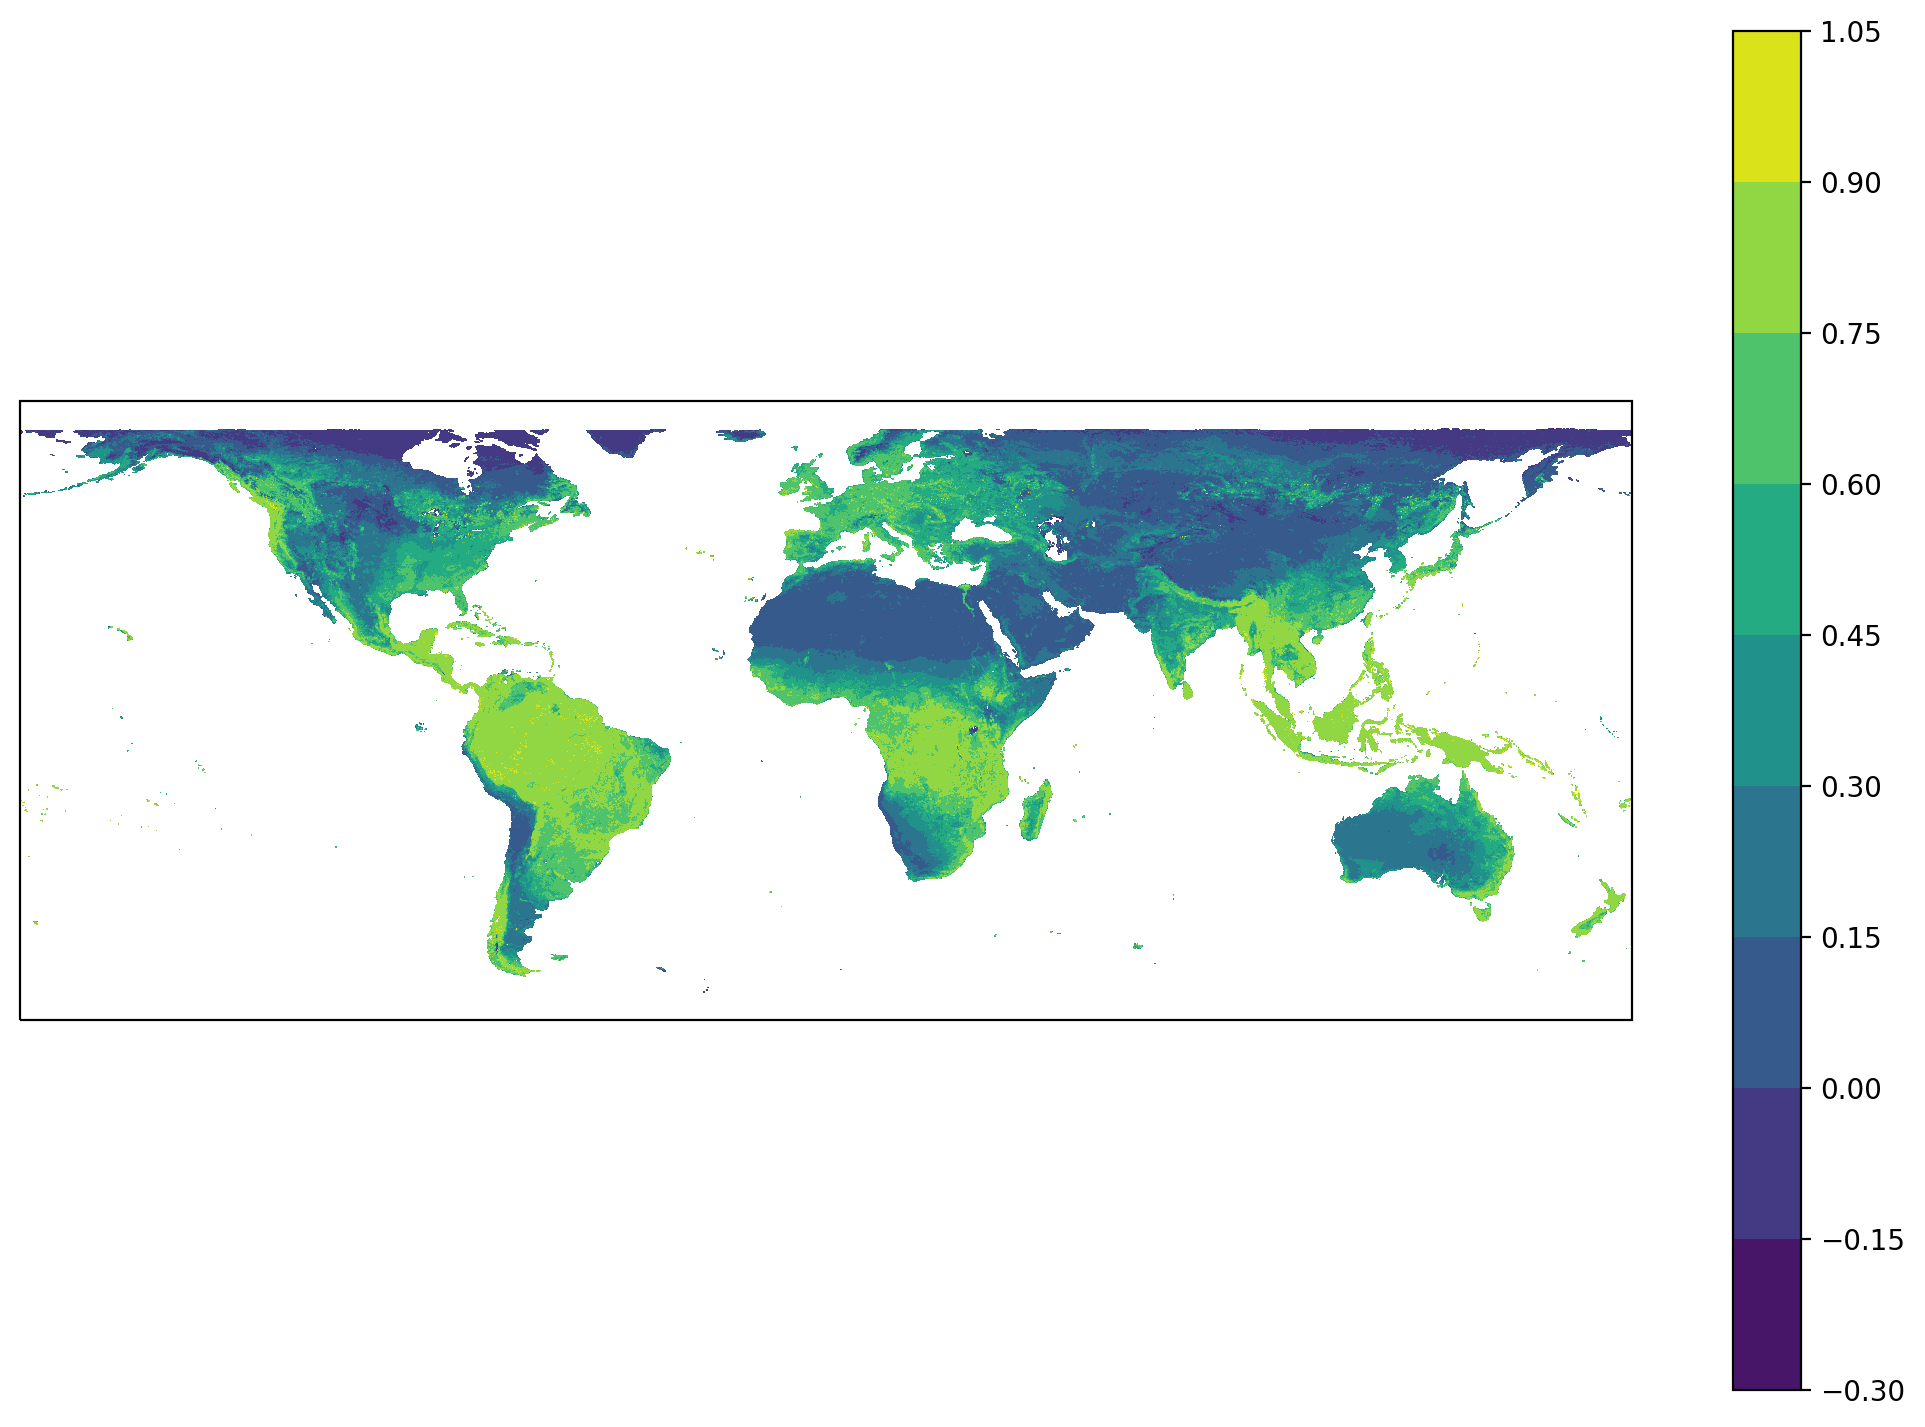

In [7]:
f = plt.figure(figsize=(13,9), dpi=200)

ax = f.add_subplot(111, projection=ccrs.PlateCarree())

plt.contourf(lon, lat, data, transform=ccrs.PlateCarree())
plt.colorbar()


In [11]:
attrs.keys()

dict_keys(['long_name', 'units', 'valid_range', '_FillValue', 'scale_factor', 'scale_factor_err', 'add_offset', 'add_offset_err', 'calibrated_nt'])

In [26]:
hdf.datasets().keys()

dict_keys(['CMG 0.05 Deg Monthly NDVI', 'CMG 0.05 Deg Monthly EVI', 'CMG 0.05 Deg Monthly VI Quality', 'CMG 0.05 Deg Monthly red reflectance', 'CMG 0.05 Deg Monthly NIR reflectance', 'CMG 0.05 Deg Monthly blue reflectance', 'CMG 0.05 Deg Monthly MIR reflectance', 'CMG 0.05 Deg Monthly Avg sun zen angle', 'CMG 0.05 Deg Monthly NDVI std dev', 'CMG 0.05 Deg Monthly EVI std dev', 'CMG 0.05 Deg Monthly #1km pix used', 'CMG 0.05 Deg Monthly #1km pix +-30deg VZ', 'CMG 0.05 Deg Monthly pixel reliability'])